# Flair NLP Framework

In [ ]:
!pip install --upgrade flair==0.11.1
!pip install torch
!pip install importlib-metadata
!pip install emoji
!pip install nltk
!pip install sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 18.0 MB/s 
     |████████████████████████████████| 4.2 MB 55.2 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 86 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 63.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 788 kB 48.3 MB/s 
     |████████████████████████████████| 1.2 MB 14.0 MB/s 
     |████████████████████████████████| 19.7 MB 16.9 MB/s 
     |████████████████████████████████| 981 kB 19.7 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 199 kB 71.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import joblib
from flair.data import Corpus, Sentence
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus, TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, TransformerDocumentEmbeddings, StackedEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.hyperparameter.param_selection import SearchSpace, Parameter
from flair.hyperparameter.param_selection import TextClassifierParamSelector, OptimizationValue
from hyperopt import hp
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from typing import List

from google.colab import drive
drive.mount('/content/drive')

import torch
from torch.optim.adam import Adam
torch.cuda.is_available()


Mounted at /content/drive


True

# Paths

In [ ]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_corpus = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/data.csv"  

path_flair = parent_path+"team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/"
path_flair_train = path_flair+"train.csv"
path_flair_dev = path_flair+"dev.csv"
path_flair_test = path_flair+"test.csv"

path_model_hyperparameters_distilroberta = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilroberta"
path_model_hyperparameters_distilroberta_mb3 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilroberta_mb3"
path_model_hyperparameters_distilroberta_mb4 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilroberta_mb4"
path_model_hyperparameters_distilroberta_mb5 = parent_path+"team project/codes/models/flair_models/twitter_cyberbullying_hyperparameters_distilroberta_mb5"


# Data Exploration

,tweet,label
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


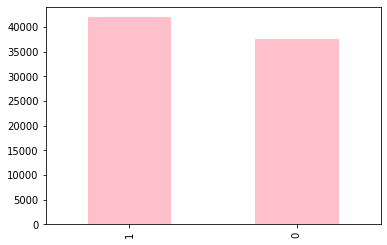

In [ ]:
data = pd.read_csv(path_corpus)

data['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))
data.head()

# Fast text format and split Dataset

In [ ]:
data['label'] = '__label__' + data['label'].astype(str)

train, test = train_test_split(data, test_size=0.2, random_state = 453, stratify=data['label'])
test, dev = train_test_split(test, test_size=0.5 , random_state = 453, stratify= test['label'])

train.to_csv(path_flair_train, sep='\t', index = False, header = False)
test.to_csv(path_flair_test, sep='\t', index = False, header = False)
dev.to_csv(path_flair_dev, sep='\t', index = False, header = False)

train.head(5)

,tweet,label
21782,@DianH4 @ExposeFalsehood .....80% of Afghan ci...,__label__1
28378,Having a high level of toxicity in your commun...,__label__1
33213,I started school in Darwin 1971...Cheesy warm ...,__label__1
59425,this is what #waiting at 2:30am for the shuttl...,__label__0
52405,home sweet second home... #vegas #girltime #d...,__label__0


# Hyperparameter tunning

## Distilroberta

In [ ]:
column_name_map = {0: "text", 1: "label_topic"}
corpus: Corpus = CSVClassificationCorpus(path_flair,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter='\t',   # tab-separated files
                                         label_type= "label")
print(corpus)

2022-05-29 19:21:16,248 Reading data from /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape
2022-05-29 19:21:16,252 Train: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/train.csv
2022-05-29 19:21:16,254 Dev: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/dev.csv
2022-05-29 19:21:16,257 Test: /content/drive/My Drive/team project/data set/dataset search/twitter_and_cyberbullying/flair_shape/test.csv
Corpus: 63722 train + 7965 dev + 7964 test sentences


In [ ]:
# Part 1 Mini Batch size 3
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 5.0e-4, 0.0005, 0.005])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[3])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilroberta-base'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilroberta_mb3, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=8)

2022-05-29 19:21:20,298 Computing label dictionary. Progress:


63722it [00:41, 1548.37it/s]

2022-05-29 19:22:01,473 Dictionary created for label 'label' with 3 values: __label__1 (seen 33590 times), __label__0 (seen 30132 times)
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

2022-05-29 19:22:01,485 ----------------------------------------------------------------------------------------------------
2022-05-29 19:22:01,490 Evaluation run: 1
2022-05-29 19:22:01,491 Evaluating parameter combination:
2022-05-29 19:22:01,495 	learning_rate: 0.0005
2022-05-29 19:22:01,497 	mini_batch_size: 3
2022-05-29 19:22:01,498 	model: distilroberta-base
2022-05-29 19:22:01,500 ----------------------------------------------------------------------------------------------------
2022-05-29 19:22:01,501 ----------------------------------------------------------------------------------------------------
2022-05-29 19:22:01,503 Training run: 1


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

2022-05-29 19:23:17,719 ----------------------------------------------------------------------------------------------------
2022-05-29 19:23:17,722 Model: "TextClassifier(
  (decoder): Linear(in_features=768, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAt

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:29, 88.93it/s]

  1%|          | 18/2655 [00:00<00:30, 86.56it/s]

  1%|1         | 27/2655 [00:00<00:30, 86.72it/s]

  1%|1         | 36/2655 [00:00<00:30, 86.20it/s]

  2%|1         | 45/2655 [00:00<00:30, 85.64it/s]

  2%|2         | 54/2655 [00:00<00:30, 85.55it/s]

  2%|2         | 63/2655 [00:00<00:29, 86.56it/s]

  3%|2         | 72/2655 [00:00<00:30, 85.88it/s]

  3%|3         | 81/2655 [00:00<00:30, 83.48it/s]

  3%|3         | 90/2655 [00:01<00:30, 83.91it/s]

  4%|3         | 100/2655 [00:01<00:29, 86.30it/s]

  4%|4         | 109/2655 [00:01<00:29, 86.22it/s]

  4%|4         | 119/2655 [00:01<00:28, 87.87it/s]

  5%|4         | 128/2655 [00:01<00:29, 86.15it/s]

  5%|5         | 137/2655 [00:01<00:28, 87.13it/s]

  5%|5         | 146/2655 [00:01<00:28, 86.82it/s]

  6%|5         | 155/2655 [00:01<00:28, 86.57it/s]

  6%|6         | 164/2655 [00:01<00:29, 84.31it/s]

  7%|6         | 173/2655 [00:02<

2022-05-29 19:36:40,931 Evaluating as a multi-label problem: False
2022-05-29 19:36:41,000 DEV : loss 0.12801851332187653 - f1-score (micro avg)  0.8836
2022-05-29 19:36:45,529 BAD EPOCHS (no improvement): 0
2022-05-29 19:36:45,537 ----------------------------------------------------------------------------------------------------
2022-05-29 19:38:02,452 epoch 2 - iter 2124/21241 - loss 0.12180984 - samples/sec: 86.38 - lr: 0.000500
2022-05-29 19:39:20,240 epoch 2 - iter 4248/21241 - loss 0.11993495 - samples/sec: 85.48 - lr: 0.000500
2022-05-29 19:40:35,643 epoch 2 - iter 6372/21241 - loss 0.12050205 - samples/sec: 88.09 - lr: 0.000500
2022-05-29 19:41:50,820 epoch 2 - iter 8496/21241 - loss 0.12206844 - samples/sec: 88.30 - lr: 0.000500
2022-05-29 19:43:06,575 epoch 2 - iter 10620/21241 - loss 0.12202329 - samples/sec: 87.68 - lr: 0.000500
2022-05-29 19:44:23,697 epoch 2 - iter 12744/21241 - loss 0.12143189 - samples/sec: 86.24 - lr: 0.000500
2022-05-29 19:45:39,804 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:31, 83.44it/s]

  1%|          | 18/2655 [00:00<00:31, 83.01it/s]

  1%|1         | 27/2655 [00:00<00:30, 85.05it/s]

  1%|1         | 36/2655 [00:00<00:31, 82.91it/s]

  2%|1         | 45/2655 [00:00<00:32, 81.45it/s]

  2%|2         | 54/2655 [00:00<00:32, 80.51it/s]

  2%|2         | 63/2655 [00:00<00:31, 82.40it/s]

  3%|2         | 72/2655 [00:00<00:31, 81.33it/s]

  3%|3         | 81/2655 [00:00<00:31, 81.70it/s]

  3%|3         | 90/2655 [00:01<00:31, 81.39it/s]

  4%|3         | 99/2655 [00:01<00:31, 82.42it/s]

  4%|4         | 108/2655 [00:01<00:30, 82.84it/s]

  4%|4         | 117/2655 [00:01<00:30, 84.50it/s]

  5%|4         | 126/2655 [00:01<00:29, 85.15it/s]

  5%|5         | 135/2655 [00:01<00:29, 86.15it/s]

  5%|5         | 145/2655 [00:01<00:28, 88.19it/s]

  6%|5         | 155/2655 [00:01<00:27, 89.97it/s]

  6%|6         | 164/2655 [00:01<00:28, 87.84it/s]

  7%|6         | 173/2655 [00:02<0

2022-05-29 19:49:59,213 Evaluating as a multi-label problem: False
2022-05-29 19:49:59,273 DEV : loss 0.11661894619464874 - f1-score (micro avg)  0.893
2022-05-29 19:50:03,770 BAD EPOCHS (no improvement): 0
2022-05-29 19:50:03,775 ----------------------------------------------------------------------------------------------------
2022-05-29 19:51:20,521 epoch 3 - iter 2124/21241 - loss 0.11447939 - samples/sec: 86.61 - lr: 0.000500
2022-05-29 19:52:37,240 epoch 3 - iter 4248/21241 - loss 0.11590700 - samples/sec: 87.25 - lr: 0.000500
2022-05-29 19:53:53,494 epoch 3 - iter 6372/21241 - loss 0.11478863 - samples/sec: 87.20 - lr: 0.000500
2022-05-29 19:55:10,409 epoch 3 - iter 8496/21241 - loss 0.11340792 - samples/sec: 86.51 - lr: 0.000500
2022-05-29 19:56:27,327 epoch 3 - iter 10620/21241 - loss 0.11464434 - samples/sec: 86.49 - lr: 0.000500
2022-05-29 19:57:44,657 epoch 3 - iter 12744/21241 - loss 0.11486917 - samples/sec: 86.27 - lr: 0.000500
2022-05-29 19:59:00,029 epoch 3 - iter 148

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 10/2655 [00:00<00:28, 93.55it/s]

  1%|          | 20/2655 [00:00<00:29, 89.29it/s]

  1%|1         | 29/2655 [00:00<00:29, 88.05it/s]

  1%|1         | 38/2655 [00:00<00:30, 87.09it/s]

  2%|1         | 47/2655 [00:00<00:30, 86.08it/s]

  2%|2         | 56/2655 [00:00<00:29, 86.65it/s]

  2%|2         | 65/2655 [00:00<00:30, 84.47it/s]

  3%|2         | 74/2655 [00:00<00:30, 85.00it/s]

  3%|3         | 83/2655 [00:00<00:31, 82.51it/s]

  4%|3         | 93/2655 [00:01<00:29, 85.78it/s]

  4%|3         | 102/2655 [00:01<00:29, 85.95it/s]

  4%|4         | 111/2655 [00:01<00:29, 85.42it/s]

  5%|4         | 120/2655 [00:01<00:29, 86.15it/s]

  5%|4         | 129/2655 [00:01<00:29, 86.35it/s]

  5%|5         | 138/2655 [00:01<00:29, 86.61it/s]

  6%|5         | 147/2655 [00:01<00:28, 87.60it/s]

  6%|5         | 157/2655 [00:01<00:28, 88.60it/s]

  6%|6         | 166/2655 [00:01<00:28, 87.83it/s]

  7%|6         | 175/2655 [00:02

2022-05-29 20:03:21,722 Evaluating as a multi-label problem: False
2022-05-29 20:03:21,785 DEV : loss 0.12347985059022903 - f1-score (micro avg)  0.8947
2022-05-29 20:03:26,259 BAD EPOCHS (no improvement): 0
2022-05-29 20:03:26,265 ----------------------------------------------------------------------------------------------------
2022-05-29 20:03:26,269 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 8/2655 [00:00<00:33, 78.34it/s]

  1%|          | 16/2655 [00:00<00:36, 71.56it/s]

  1%|          | 25/2655 [00:00<00:34, 76.69it/s]

  1%|1         | 34/2655 [00:00<00:32, 80.06it/s]

  2%|1         | 44/2655 [00:00<00:30, 84.55it/s]

  2%|1         | 53/2655 [00:00<00:31, 82.15it/s]

  2%|2         | 62/2655 [00:00<00:30, 83.82it/s]

  3%|2         | 71/2655 [00:00<00:30, 84.23it/s]

  3%|3         | 80/2655 [00:00<00:30, 84.85it/s]

  3%|3         | 89/2655 [00:01<00:30, 85.37it/s]

  4%|3         | 99/2655 [00:01<00:28, 88.21it/s]

  4%|4         | 110/2655 [00:01<00:27, 91.97it/s]

  5%|4         | 120/2655 [00:01<00:27, 92.66it/s]

  5%|4         | 130/2655 [00:01<00:27, 90.28it/s]

  5%|5         | 140/2655 [00:01<00:27, 89.91it/s]

  6%|5         | 150/2655 [00:01<00:28, 86.97it/s]

  6%|5         | 159/2655 [00:01<00:28, 87.31it/s]

  6%|6         | 168/2655 [00:01<00:28, 87.68it/s]

  7%|6         | 177/2655 [00:02<0

2022-05-29 20:03:58,184 Evaluating as a multi-label problem: False
2022-05-29 20:03:58,244 0.8988	0.8988	0.8988	0.8988
2022-05-29 20:03:58,246 
Results:
- F-score (micro) 0.8988
- F-score (macro) 0.8975
- Accuracy 0.8988

By class:
              precision    recall  f1-score   support

  __label__1     0.8638    0.9593    0.9090      4199
  __label__0     0.9482    0.8313    0.8859      3765

    accuracy                         0.8988      7964
   macro avg     0.9060    0.8953    0.8975      7964
weighted avg     0.9037    0.8988    0.8981      7964

2022-05-29 20:03:58,252 ----------------------------------------------------------------------------------------------------
2022-05-29 20:03:58,257 ----------------------------------------------------------------------------------------------------
2022-05-29 20:03:58,259 Done evaluating parameter combination:
2022-05-29 20:03:58,262 	learning_rate: 0.0005
2022-05-29 20:03:58,263 	mini_batch_size: 3
2022-05-29 20:03:58,264 	model: disti

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:29, 88.76it/s]

  1%|          | 18/2655 [00:00<00:31, 84.49it/s]

  1%|1         | 27/2655 [00:00<00:30, 86.83it/s]

  1%|1         | 36/2655 [00:00<00:30, 84.56it/s]

  2%|1         | 45/2655 [00:00<00:30, 84.36it/s]

  2%|2         | 54/2655 [00:00<00:30, 85.52it/s]

  2%|2         | 63/2655 [00:00<00:30, 85.80it/s]

  3%|2         | 72/2655 [00:00<00:30, 84.32it/s]

  3%|3         | 81/2655 [00:00<00:30, 83.07it/s]

  3%|3         | 90/2655 [00:01<00:31, 82.42it/s]

  4%|3         | 99/2655 [00:01<00:30, 83.16it/s]

  4%|4         | 108/2655 [00:01<00:30, 83.70it/s]

  4%|4         | 117/2655 [00:01<00:30, 82.29it/s]

  5%|4         | 126/2655 [00:01<00:31, 79.29it/s]

  5%|5         | 135/2655 [00:01<00:31, 81.20it/s]

  5%|5         | 145/2655 [00:01<00:29, 84.01it/s]

  6%|5         | 154/2655 [00:01<00:30, 82.02it/s]

  6%|6         | 163/2655 [00:01<00:31, 80.29it/s]

  6%|6         | 172/2655 [00:02<0

2022-05-29 20:17:58,635 Evaluating as a multi-label problem: False
2022-05-29 20:17:58,704 DEV : loss 0.15047454833984375 - f1-score (micro avg)  0.8525
2022-05-29 20:18:03,209 BAD EPOCHS (no improvement): 0
2022-05-29 20:18:03,225 ----------------------------------------------------------------------------------------------------
2022-05-29 20:19:20,830 epoch 2 - iter 2124/21241 - loss 0.14591804 - samples/sec: 85.70 - lr: 0.000050
2022-05-29 20:20:37,642 epoch 2 - iter 4248/21241 - loss 0.14123878 - samples/sec: 86.59 - lr: 0.000050
2022-05-29 20:21:53,447 epoch 2 - iter 6372/21241 - loss 0.14056365 - samples/sec: 87.68 - lr: 0.000050
2022-05-29 20:23:09,104 epoch 2 - iter 8496/21241 - loss 0.14246069 - samples/sec: 87.83 - lr: 0.000050
2022-05-29 20:24:26,367 epoch 2 - iter 10620/21241 - loss 0.14186470 - samples/sec: 86.05 - lr: 0.000050
2022-05-29 20:25:42,821 epoch 2 - iter 12744/21241 - loss 0.14171772 - samples/sec: 86.99 - lr: 0.000050
2022-05-29 20:26:59,509 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:30, 86.30it/s]

  1%|          | 18/2655 [00:00<00:33, 79.54it/s]

  1%|1         | 27/2655 [00:00<00:32, 81.71it/s]

  1%|1         | 36/2655 [00:00<00:31, 83.37it/s]

  2%|1         | 45/2655 [00:00<00:31, 83.27it/s]

  2%|2         | 54/2655 [00:00<00:31, 82.37it/s]

  2%|2         | 63/2655 [00:00<00:32, 80.84it/s]

  3%|2         | 72/2655 [00:00<00:31, 81.03it/s]

  3%|3         | 81/2655 [00:00<00:32, 79.48it/s]

  3%|3         | 90/2655 [00:01<00:31, 80.58it/s]

  4%|3         | 99/2655 [00:01<00:31, 81.16it/s]

  4%|4         | 108/2655 [00:01<00:31, 81.65it/s]

  4%|4         | 117/2655 [00:01<00:30, 82.34it/s]

  5%|4         | 126/2655 [00:01<00:31, 80.39it/s]

  5%|5         | 135/2655 [00:01<00:31, 80.78it/s]

  5%|5         | 144/2655 [00:01<00:31, 80.80it/s]

  6%|5         | 153/2655 [00:01<00:30, 81.93it/s]

  6%|6         | 162/2655 [00:02<00:31, 77.95it/s]

  6%|6         | 171/2655 [00:02<0

2022-05-29 20:31:26,236 Evaluating as a multi-label problem: False
2022-05-29 20:31:26,301 DEV : loss 0.14719074964523315 - f1-score (micro avg)  0.8654
2022-05-29 20:31:30,544 BAD EPOCHS (no improvement): 0
2022-05-29 20:31:30,550 ----------------------------------------------------------------------------------------------------
2022-05-29 20:32:48,361 epoch 3 - iter 2124/21241 - loss 0.13491893 - samples/sec: 85.45 - lr: 0.000050
2022-05-29 20:34:07,263 epoch 3 - iter 4248/21241 - loss 0.13476875 - samples/sec: 84.91 - lr: 0.000050
2022-05-29 20:35:25,503 epoch 3 - iter 6372/21241 - loss 0.13731582 - samples/sec: 85.04 - lr: 0.000050
2022-05-29 20:36:43,558 epoch 3 - iter 8496/21241 - loss 0.13834251 - samples/sec: 85.21 - lr: 0.000050
2022-05-29 20:38:01,535 epoch 3 - iter 10620/21241 - loss 0.13774099 - samples/sec: 85.60 - lr: 0.000050
2022-05-29 20:39:17,615 epoch 3 - iter 12744/21241 - loss 0.13835358 - samples/sec: 87.34 - lr: 0.000050
2022-05-29 20:40:33,711 epoch 3 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 10/2655 [00:00<00:28, 93.82it/s]

  1%|          | 20/2655 [00:00<00:28, 91.32it/s]

  1%|1         | 30/2655 [00:00<00:29, 89.11it/s]

  1%|1         | 39/2655 [00:00<00:30, 85.61it/s]

  2%|1         | 48/2655 [00:00<00:30, 85.58it/s]

  2%|2         | 57/2655 [00:00<00:30, 84.24it/s]

  2%|2         | 66/2655 [00:00<00:30, 83.89it/s]

  3%|2         | 75/2655 [00:00<00:30, 83.47it/s]

  3%|3         | 84/2655 [00:01<00:32, 79.66it/s]

  4%|3         | 93/2655 [00:01<00:31, 81.42it/s]

  4%|3         | 102/2655 [00:01<00:31, 81.18it/s]

  4%|4         | 111/2655 [00:01<00:30, 82.32it/s]

  5%|4         | 120/2655 [00:01<00:30, 82.03it/s]

  5%|4         | 129/2655 [00:01<00:30, 82.50it/s]

  5%|5         | 138/2655 [00:01<00:29, 84.07it/s]

  6%|5         | 147/2655 [00:01<00:29, 85.03it/s]

  6%|5         | 156/2655 [00:01<00:30, 80.89it/s]

  6%|6         | 165/2655 [00:01<00:31, 78.53it/s]

  7%|6         | 174/2655 [00:02

2022-05-29 20:44:55,315 Evaluating as a multi-label problem: False
2022-05-29 20:44:55,382 DEV : loss 0.1411760300397873 - f1-score (micro avg)  0.8714
2022-05-29 20:44:59,856 BAD EPOCHS (no improvement): 0
2022-05-29 20:44:59,865 ----------------------------------------------------------------------------------------------------
2022-05-29 20:44:59,871 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 8/2655 [00:00<00:37, 71.43it/s]

  1%|          | 16/2655 [00:00<00:38, 68.99it/s]

  1%|          | 24/2655 [00:00<00:37, 71.03it/s]

  1%|1         | 32/2655 [00:00<00:35, 74.16it/s]

  2%|1         | 41/2655 [00:00<00:33, 78.34it/s]

  2%|1         | 50/2655 [00:00<00:31, 81.54it/s]

  2%|2         | 59/2655 [00:00<00:31, 82.85it/s]

  3%|2         | 68/2655 [00:00<00:30, 84.39it/s]

  3%|2         | 77/2655 [00:00<00:30, 85.06it/s]

  3%|3         | 86/2655 [00:01<00:31, 81.30it/s]

  4%|3         | 96/2655 [00:01<00:30, 85.09it/s]

  4%|3         | 106/2655 [00:01<00:29, 87.86it/s]

  4%|4         | 115/2655 [00:01<00:28, 87.73it/s]

  5%|4         | 125/2655 [00:01<00:28, 89.27it/s]

  5%|5         | 134/2655 [00:01<00:28, 89.33it/s]

  5%|5         | 143/2655 [00:01<00:28, 88.52it/s]

  6%|5         | 153/2655 [00:01<00:27, 89.60it/s]

  6%|6         | 163/2655 [00:01<00:26, 92.46it/s]

  7%|6         | 173/2655 [00:02<0

2022-05-29 20:45:32,174 Evaluating as a multi-label problem: False
2022-05-29 20:45:32,232 0.872	0.872	0.872	0.872
2022-05-29 20:45:32,234 
Results:
- F-score (micro) 0.872
- F-score (macro) 0.8716
- Accuracy 0.872

By class:
              precision    recall  f1-score   support

  __label__1     0.8745    0.8843    0.8793      4199
  __label__0     0.8693    0.8584    0.8638      3765

    accuracy                         0.8720      7964
   macro avg     0.8719    0.8713    0.8716      7964
weighted avg     0.8720    0.8720    0.8720      7964

2022-05-29 20:45:32,240 ----------------------------------------------------------------------------------------------------
2022-05-29 20:45:32,246 ----------------------------------------------------------------------------------------------------
2022-05-29 20:45:32,252 Done evaluating parameter combination:
2022-05-29 20:45:32,253 	learning_rate: 5e-05
2022-05-29 20:45:32,255 	mini_batch_size: 3
2022-05-29 20:45:32,258 	model: distilrobert

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:30, 88.01it/s]

  1%|          | 18/2655 [00:00<00:29, 88.17it/s]

  1%|1         | 27/2655 [00:00<00:30, 86.72it/s]

  1%|1         | 36/2655 [00:00<00:29, 87.54it/s]

  2%|1         | 46/2655 [00:00<00:29, 88.73it/s]

  2%|2         | 56/2655 [00:00<00:28, 90.08it/s]

  2%|2         | 66/2655 [00:00<00:28, 90.08it/s]

  3%|2         | 76/2655 [00:00<00:28, 90.48it/s]

  3%|3         | 86/2655 [00:00<00:29, 86.05it/s]

  4%|3         | 95/2655 [00:01<00:29, 85.99it/s]

  4%|3         | 104/2655 [00:01<00:29, 85.81it/s]

  4%|4         | 113/2655 [00:01<00:29, 86.77it/s]

  5%|4         | 122/2655 [00:01<00:29, 86.85it/s]

  5%|4         | 131/2655 [00:01<00:29, 86.91it/s]

  5%|5         | 140/2655 [00:01<00:28, 87.26it/s]

  6%|5         | 150/2655 [00:01<00:27, 89.85it/s]

  6%|5         | 159/2655 [00:01<00:28, 87.48it/s]

  6%|6         | 168/2655 [00:01<00:28, 86.42it/s]

  7%|6         | 177/2655 [00:02<

2022-05-29 20:59:29,704 Evaluating as a multi-label problem: False
2022-05-29 20:59:29,767 DEV : loss 0.09139636904001236 - f1-score (micro avg)  0.8997
2022-05-29 20:59:34,167 BAD EPOCHS (no improvement): 0
2022-05-29 20:59:34,176 ----------------------------------------------------------------------------------------------------
2022-05-29 21:00:49,515 epoch 2 - iter 2124/21241 - loss 0.09456446 - samples/sec: 88.13 - lr: 0.005000
2022-05-29 21:02:05,820 epoch 2 - iter 4248/21241 - loss 0.09276292 - samples/sec: 87.13 - lr: 0.005000
2022-05-29 21:03:21,897 epoch 2 - iter 6372/21241 - loss 0.09180732 - samples/sec: 87.42 - lr: 0.005000
2022-05-29 21:04:38,366 epoch 2 - iter 8496/21241 - loss 0.09300504 - samples/sec: 86.93 - lr: 0.005000
2022-05-29 21:05:54,085 epoch 2 - iter 10620/21241 - loss 0.09217851 - samples/sec: 87.77 - lr: 0.005000
2022-05-29 21:07:09,910 epoch 2 - iter 12744/21241 - loss 0.09257157 - samples/sec: 87.66 - lr: 0.005000
2022-05-29 21:08:25,268 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 10/2655 [00:00<00:28, 91.77it/s]

  1%|          | 20/2655 [00:00<00:31, 84.19it/s]

  1%|1         | 29/2655 [00:00<00:31, 83.49it/s]

  1%|1         | 38/2655 [00:00<00:31, 82.26it/s]

  2%|1         | 47/2655 [00:00<00:32, 80.84it/s]

  2%|2         | 56/2655 [00:00<00:32, 80.29it/s]

  2%|2         | 65/2655 [00:00<00:31, 80.97it/s]

  3%|2         | 74/2655 [00:00<00:31, 81.88it/s]

  3%|3         | 83/2655 [00:01<00:31, 81.03it/s]

  3%|3         | 92/2655 [00:01<00:30, 82.78it/s]

  4%|3         | 101/2655 [00:01<00:30, 83.36it/s]

  4%|4         | 110/2655 [00:01<00:30, 83.43it/s]

  4%|4         | 119/2655 [00:01<00:30, 83.63it/s]

  5%|4         | 128/2655 [00:01<00:30, 82.04it/s]

  5%|5         | 137/2655 [00:01<00:30, 83.41it/s]

  5%|5         | 146/2655 [00:01<00:30, 82.48it/s]

  6%|5         | 155/2655 [00:01<00:29, 83.79it/s]

  6%|6         | 164/2655 [00:01<00:29, 84.09it/s]

  7%|6         | 173/2655 [00:02

2022-05-29 21:12:46,678 Evaluating as a multi-label problem: False
2022-05-29 21:12:46,744 DEV : loss 0.09441531449556351 - f1-score (micro avg)  0.9081
2022-05-29 21:12:51,247 BAD EPOCHS (no improvement): 0
2022-05-29 21:12:51,270 ----------------------------------------------------------------------------------------------------
2022-05-29 21:14:09,259 epoch 3 - iter 2124/21241 - loss 0.08483265 - samples/sec: 85.27 - lr: 0.005000
2022-05-29 21:15:26,191 epoch 3 - iter 4248/21241 - loss 0.08433724 - samples/sec: 86.43 - lr: 0.005000
2022-05-29 21:16:42,953 epoch 3 - iter 6372/21241 - loss 0.08442950 - samples/sec: 86.60 - lr: 0.005000
2022-05-29 21:17:59,328 epoch 3 - iter 8496/21241 - loss 0.08441757 - samples/sec: 87.04 - lr: 0.005000
2022-05-29 21:19:13,991 epoch 3 - iter 10620/21241 - loss 0.08385287 - samples/sec: 88.97 - lr: 0.005000
2022-05-29 21:20:28,853 epoch 3 - iter 12744/21241 - loss 0.08305520 - samples/sec: 88.76 - lr: 0.005000
2022-05-29 21:21:45,084 epoch 3 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:30, 87.61it/s]

  1%|          | 18/2655 [00:00<00:31, 83.87it/s]

  1%|1         | 27/2655 [00:00<00:30, 85.85it/s]

  1%|1         | 36/2655 [00:00<00:30, 85.86it/s]

  2%|1         | 45/2655 [00:00<00:30, 86.51it/s]

  2%|2         | 54/2655 [00:00<00:30, 84.90it/s]

  2%|2         | 63/2655 [00:00<00:30, 86.03it/s]

  3%|2         | 72/2655 [00:00<00:30, 84.35it/s]

  3%|3         | 81/2655 [00:00<00:31, 81.30it/s]

  3%|3         | 91/2655 [00:01<00:30, 85.13it/s]

  4%|3         | 101/2655 [00:01<00:29, 86.97it/s]

  4%|4         | 110/2655 [00:01<00:29, 86.75it/s]

  4%|4         | 119/2655 [00:01<00:29, 87.30it/s]

  5%|4         | 129/2655 [00:01<00:28, 88.60it/s]

  5%|5         | 139/2655 [00:01<00:27, 90.91it/s]

  6%|5         | 149/2655 [00:01<00:28, 86.63it/s]

  6%|5         | 158/2655 [00:01<00:29, 85.67it/s]

  6%|6         | 167/2655 [00:01<00:29, 84.17it/s]

  7%|6         | 176/2655 [00:02<

2022-05-29 21:26:06,243 Evaluating as a multi-label problem: False
2022-05-29 21:26:06,307 DEV : loss 0.09558131545782089 - f1-score (micro avg)  0.9036
2022-05-29 21:26:10,790 BAD EPOCHS (no improvement): 1
2022-05-29 21:26:10,799 ----------------------------------------------------------------------------------------------------
2022-05-29 21:26:10,808 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 8/2655 [00:00<00:35, 75.17it/s]

  1%|          | 16/2655 [00:00<00:37, 71.29it/s]

  1%|          | 24/2655 [00:00<00:35, 73.58it/s]

  1%|1         | 33/2655 [00:00<00:33, 77.42it/s]

  2%|1         | 42/2655 [00:00<00:32, 81.11it/s]

  2%|1         | 51/2655 [00:00<00:31, 82.24it/s]

  2%|2         | 60/2655 [00:00<00:31, 83.66it/s]

  3%|2         | 69/2655 [00:00<00:30, 84.16it/s]

  3%|2         | 78/2655 [00:00<00:30, 85.88it/s]

  3%|3         | 87/2655 [00:01<00:29, 87.03it/s]

  4%|3         | 96/2655 [00:01<00:30, 84.14it/s]

  4%|3         | 105/2655 [00:01<00:30, 84.76it/s]

  4%|4         | 114/2655 [00:01<00:30, 84.66it/s]

  5%|4         | 123/2655 [00:01<00:29, 85.59it/s]

  5%|4         | 132/2655 [00:01<00:29, 84.26it/s]

  5%|5         | 141/2655 [00:01<00:30, 83.76it/s]

  6%|5         | 150/2655 [00:01<00:29, 84.04it/s]

  6%|5         | 159/2655 [00:01<00:29, 85.49it/s]

  6%|6         | 168/2655 [00:02<0

2022-05-29 21:26:42,315 Evaluating as a multi-label problem: False
2022-05-29 21:26:42,373 0.9098	0.9098	0.9098	0.9098
2022-05-29 21:26:42,375 
Results:
- F-score (micro) 0.9098
- F-score (macro) 0.9096
- Accuracy 0.9098

By class:
              precision    recall  f1-score   support

  __label__1     0.9151    0.9138    0.9144      4199
  __label__0     0.9040    0.9054    0.9047      3765

    accuracy                         0.9098      7964
   macro avg     0.9096    0.9096    0.9096      7964
weighted avg     0.9099    0.9098    0.9098      7964

2022-05-29 21:26:42,384 ----------------------------------------------------------------------------------------------------
2022-05-29 21:26:42,391 ----------------------------------------------------------------------------------------------------
2022-05-29 21:26:42,392 Done evaluating parameter combination:
2022-05-29 21:26:42,396 	learning_rate: 0.005
2022-05-29 21:26:42,400 	mini_batch_size: 3
2022-05-29 21:26:42,404 	model: distil

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:31, 85.34it/s]

  1%|          | 18/2655 [00:00<00:33, 79.70it/s]

  1%|1         | 27/2655 [00:00<00:32, 81.09it/s]

  1%|1         | 36/2655 [00:00<00:32, 81.74it/s]

  2%|1         | 45/2655 [00:00<00:32, 80.48it/s]

  2%|2         | 54/2655 [00:00<00:33, 78.00it/s]

  2%|2         | 62/2655 [00:00<00:33, 78.46it/s]

  3%|2         | 70/2655 [00:00<00:33, 77.96it/s]

  3%|2         | 78/2655 [00:01<00:34, 74.42it/s]

  3%|3         | 86/2655 [00:01<00:33, 75.65it/s]

  4%|3         | 95/2655 [00:01<00:32, 79.60it/s]

  4%|3         | 104/2655 [00:01<00:31, 80.76it/s]

  4%|4         | 113/2655 [00:01<00:30, 82.80it/s]

  5%|4         | 122/2655 [00:01<00:30, 83.92it/s]

  5%|4         | 131/2655 [00:01<00:31, 81.34it/s]

  5%|5         | 140/2655 [00:01<00:30, 82.23it/s]

  6%|5         | 149/2655 [00:01<00:30, 81.35it/s]

  6%|5         | 158/2655 [00:01<00:30, 81.13it/s]

  6%|6         | 167/2655 [00:02<0

2022-05-29 21:40:49,814 Evaluating as a multi-label problem: False
2022-05-29 21:40:49,876 DEV : loss 0.08518743515014648 - f1-score (micro avg)  0.9032
2022-05-29 21:40:54,350 BAD EPOCHS (no improvement): 0
2022-05-29 21:40:54,361 ----------------------------------------------------------------------------------------------------
2022-05-29 21:42:10,999 epoch 2 - iter 2124/21241 - loss 0.09037747 - samples/sec: 86.75 - lr: 0.005000
2022-05-29 21:43:28,269 epoch 2 - iter 4248/21241 - loss 0.09305212 - samples/sec: 86.72 - lr: 0.005000
2022-05-29 21:44:45,132 epoch 2 - iter 6372/21241 - loss 0.09229643 - samples/sec: 86.59 - lr: 0.005000
2022-05-29 21:46:01,556 epoch 2 - iter 8496/21241 - loss 0.09150516 - samples/sec: 87.02 - lr: 0.005000
2022-05-29 21:47:16,920 epoch 2 - iter 10620/21241 - loss 0.09086230 - samples/sec: 88.16 - lr: 0.005000
2022-05-29 21:48:32,641 epoch 2 - iter 12744/21241 - loss 0.09010446 - samples/sec: 88.04 - lr: 0.005000
2022-05-29 21:49:47,632 epoch 2 - iter 14

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:31, 84.89it/s]

  1%|          | 18/2655 [00:00<00:31, 83.62it/s]

  1%|1         | 27/2655 [00:00<00:31, 82.52it/s]

  1%|1         | 36/2655 [00:00<00:31, 83.02it/s]

  2%|1         | 45/2655 [00:00<00:30, 85.01it/s]

  2%|2         | 54/2655 [00:00<00:30, 84.71it/s]

  2%|2         | 63/2655 [00:00<00:30, 85.68it/s]

  3%|2         | 72/2655 [00:00<00:30, 85.11it/s]

  3%|3         | 81/2655 [00:00<00:30, 84.01it/s]

  3%|3         | 90/2655 [00:01<00:31, 80.57it/s]

  4%|3         | 99/2655 [00:01<00:31, 81.69it/s]

  4%|4         | 108/2655 [00:01<00:30, 82.37it/s]

  4%|4         | 117/2655 [00:01<00:30, 82.44it/s]

  5%|4         | 126/2655 [00:01<00:30, 81.84it/s]

  5%|5         | 135/2655 [00:01<00:30, 83.48it/s]

  5%|5         | 144/2655 [00:01<00:29, 85.32it/s]

  6%|5         | 153/2655 [00:01<00:28, 86.40it/s]

  6%|6         | 162/2655 [00:01<00:29, 83.77it/s]

  6%|6         | 171/2655 [00:02<0

2022-05-29 21:54:07,643 Evaluating as a multi-label problem: False
2022-05-29 21:54:07,703 DEV : loss 0.0895923301577568 - f1-score (micro avg)  0.9066
2022-05-29 21:54:12,305 BAD EPOCHS (no improvement): 0
2022-05-29 21:54:12,313 ----------------------------------------------------------------------------------------------------
2022-05-29 21:55:28,476 epoch 3 - iter 2124/21241 - loss 0.07992588 - samples/sec: 87.30 - lr: 0.005000
2022-05-29 21:56:44,853 epoch 3 - iter 4248/21241 - loss 0.07975623 - samples/sec: 87.13 - lr: 0.005000
2022-05-29 21:58:01,059 epoch 3 - iter 6372/21241 - loss 0.07973730 - samples/sec: 87.17 - lr: 0.005000
2022-05-29 21:59:16,658 epoch 3 - iter 8496/21241 - loss 0.08043760 - samples/sec: 87.93 - lr: 0.005000
2022-05-29 22:00:33,280 epoch 3 - iter 10620/21241 - loss 0.08064857 - samples/sec: 86.75 - lr: 0.005000
2022-05-29 22:01:48,983 epoch 3 - iter 12744/21241 - loss 0.08065406 - samples/sec: 87.80 - lr: 0.005000
2022-05-29 22:03:04,829 epoch 3 - iter 148

  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 9/2655 [00:00<00:29, 89.32it/s]

  1%|          | 18/2655 [00:00<00:30, 86.79it/s]

  1%|1         | 27/2655 [00:00<00:30, 85.74it/s]

  1%|1         | 36/2655 [00:00<00:30, 86.77it/s]

  2%|1         | 45/2655 [00:00<00:30, 85.21it/s]

  2%|2         | 54/2655 [00:00<00:31, 82.75it/s]

  2%|2         | 63/2655 [00:00<00:30, 83.88it/s]

  3%|2         | 72/2655 [00:00<00:32, 80.67it/s]

  3%|3         | 81/2655 [00:00<00:31, 81.79it/s]

  3%|3         | 90/2655 [00:01<00:30, 83.18it/s]

  4%|3         | 100/2655 [00:01<00:29, 85.47it/s]

  4%|4         | 109/2655 [00:01<00:29, 84.88it/s]

  4%|4         | 118/2655 [00:01<00:29, 85.56it/s]

  5%|4         | 127/2655 [00:01<00:29, 84.27it/s]

  5%|5         | 137/2655 [00:01<00:29, 86.63it/s]

  5%|5         | 146/2655 [00:01<00:28, 87.23it/s]

  6%|5         | 155/2655 [00:01<00:28, 86.47it/s]

  6%|6         | 164/2655 [00:01<00:29, 83.58it/s]

  7%|6         | 173/2655 [00:02<

2022-05-29 22:07:25,090 Evaluating as a multi-label problem: False
2022-05-29 22:07:25,149 DEV : loss 0.08667333424091339 - f1-score (micro avg)  0.9105
2022-05-29 22:07:29,560 BAD EPOCHS (no improvement): 0
2022-05-29 22:07:29,566 ----------------------------------------------------------------------------------------------------
2022-05-29 22:07:29,569 Testing using last state of model ...


  0%|          | 0/2655 [00:00<?, ?it/s]

  0%|          | 7/2655 [00:00<00:38, 69.23it/s]

  1%|          | 14/2655 [00:00<00:39, 67.10it/s]

  1%|          | 21/2655 [00:00<00:39, 66.70it/s]

  1%|1         | 30/2655 [00:00<00:36, 72.69it/s]

  1%|1         | 39/2655 [00:00<00:33, 77.25it/s]

  2%|1         | 48/2655 [00:00<00:32, 79.96it/s]

  2%|2         | 57/2655 [00:00<00:32, 80.89it/s]

  2%|2         | 66/2655 [00:00<00:31, 81.77it/s]

  3%|2         | 75/2655 [00:00<00:32, 80.32it/s]

  3%|3         | 84/2655 [00:01<00:31, 81.26it/s]

  4%|3         | 93/2655 [00:01<00:30, 83.14it/s]

  4%|3         | 102/2655 [00:01<00:30, 84.79it/s]

  4%|4         | 112/2655 [00:01<00:29, 86.56it/s]

  5%|4         | 121/2655 [00:01<00:28, 87.49it/s]

  5%|4         | 130/2655 [00:01<00:28, 87.98it/s]

  5%|5         | 139/2655 [00:01<00:28, 88.06it/s]

  6%|5         | 148/2655 [00:01<00:29, 85.91it/s]

  6%|5         | 157/2655 [00:01<00:28, 86.67it/s]

  6%|6         | 166/2655 [00:02<0

2022-05-29 22:08:00,989 Evaluating as a multi-label problem: False
2022-05-29 22:08:01,050 0.917	0.917	0.917	0.917
2022-05-29 22:08:01,052 
Results:
- F-score (micro) 0.917
- F-score (macro) 0.9166
- Accuracy 0.917

By class:
              precision    recall  f1-score   support

  __label__1     0.9125    0.9319    0.9221      4199
  __label__0     0.9222    0.9004    0.9112      3765

    accuracy                         0.9170      7964
   macro avg     0.9174    0.9161    0.9166      7964
weighted avg     0.9171    0.9170    0.9169      7964

2022-05-29 22:08:01,058 ----------------------------------------------------------------------------------------------------
2022-05-29 22:08:01,065 ----------------------------------------------------------------------------------------------------
2022-05-29 22:08:01,068 Done evaluating parameter combination:
2022-05-29 22:08:01,071 	learning_rate: 0.005
2022-05-29 22:08:01,073 	mini_batch_size: 3
2022-05-29 22:08:01,076 	model: distilrobert

In [ ]:
# Part 2 Mini Batch size 4
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 5.0e-4, 0.0005, 0.005])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[4])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilroberta-base'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilroberta_mb4, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=8)

In [ ]:
# Part 3 Mini Batch size 5
search_space = SearchSpace()

# define training hyperparameters
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[5.0e-5, 5.0e-4, 0.0005, 0.005])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[5])

# define transformer embedding hyperparameters
search_space.add(Parameter.TRANSFORMER_MODEL, hp.choice, options=['distilroberta-base'])

# what label do we want to predict?
label_type = 'label'

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus,
    label_type, 
    False, 
    path_model_hyperparameters_distilroberta_mb5, 
    max_epochs=3, 
    fine_tune=True,
    training_runs=1,
    optimization_value=OptimizationValue.DEV_LOSS
)

# start the optimization
param_selector.optimize(search_space, max_evals=8)